In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_and_preprocess_wikitext(file_path, max_sentences=1000):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Use regular expressions to split the text into sentences
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [sentence.strip() for sentence in sentences if len(sentence.split()) <= MAX_LENGTH]
    
    return sentences[:max_sentences]


MAX_LENGTH = 10
max_sentences = 1000
file_path = "wikitext-2/wiki.train.tokens"
wikitext_sentences = load_and_preprocess_wikitext(file_path, max_sentences=max_sentences)

# Print the first few sentences to check
wikitext_sentences[:10]

['A large team of writers handled the script .',
 '<unk> can switch classes by changing their assigned weapon .',
 'Development work took approximately one year .',
 'The newer systems were decided upon early in development .',
 'The main color of the Nameless was black .',
 'The anime opening was produced by Production I.G.',
 'The game was released January 27 , 2011 .',
 "He also positively noted the story 's serious tone .",
 'The anime was first announced in November 2010 .',
 'Lee of the U.S.']

In [3]:
# Define constants
MAX_LENGTH = 10  # Maximum sentence length
VOCAB_SIZE = 50  # For simplicity, let's assume 50 unique tokens (including padding, start, end tokens)
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
LATENT_DIM = 32  # Dimension of the latent space

# Gumbel softmax temperature
TAU = 1.0


In [4]:
# Define the Transformer-based CVAE model
class TransformerEncoder(nn.Module):
    def __init__(self, d_model=EMBEDDING_DIM, nhead=4, num_layers=2):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers
        )
        self.fc_logits = nn.Linear(d_model, LATENT_DIM)

    def forward(self, x):
        embedded = self.embedding(x).permute(1, 0, 2)  # Transformer expects seq_len, batch, features
        transformed = self.transformer_encoder(embedded)
        # Use the final state to predict logits for latent space
        logits = self.fc_logits(transformed[-1])
        return logits


class TransformerDecoder(nn.Module):
    def __init__(self, d_model=EMBEDDING_DIM, nhead=4, num_layers=2):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead), num_layers
        )
        self.fc_out = nn.Linear(d_model, VOCAB_SIZE)
        self.fc_z = nn.Linear(LATENT_DIM, d_model)  # Convert z to feature size for transformer

    def forward(self, x, z):
        embedded = self.embedding(x).permute(1, 0, 2)
        z_adjusted = self.fc_z(z).unsqueeze(0)
        output = self.transformer_decoder(embedded, z_adjusted)
        return self.fc_out(output.permute(1, 0, 2))


class TransformerCVAE(nn.Module):
    def __init__(self):
        super(TransformerCVAE, self).__init__()
        self.encoder = TransformerEncoder()
        self.decoder = TransformerDecoder()

    def reparameterize(self, logits):
        return F.gumbel_softmax(logits, tau=TAU, hard=True, dim=-1)

    def forward(self, x):
        logits = self.encoder(x)
        z = self.reparameterize(logits)
        return self.decoder(x, z), logits

transformer_cvae = TransformerCVAE()

# # Check model architecture
# transformer_cvae


In [5]:
# loss function
def loss_function(recon_x, x, logits):
    recon_loss = F.cross_entropy(recon_x.permute(0, 2, 1), x, reduction='sum')
    
    # Regularization loss: entropy of the logits
    probs = F.softmax(logits, dim=-1)
    log_probs = F.log_softmax(logits, dim=-1)
    reg_loss = -torch.sum(probs * log_probs)
    
    return recon_loss + reg_loss

# Initialize optimizer for the new model
optimizer_gumbel = torch.optim.Adam(transformer_cvae.parameters())

# Training loop for the new model
def train(epoch, data, model, optimizer):
    model.train()
    train_loss = 0
    for i in range(len(data)):
        sentence = data[i].unsqueeze(0)
        optimizer.zero_grad()
        recon_sentence, logits = model(sentence)
        loss = loss_function(recon_sentence, sentence, logits)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f"Epoch: {epoch}, Loss: {train_loss / len(data)}")

In [6]:
# Load the provided wiki dataset
with open("wikitext-2/wiki.train.tokens", "r", encoding="utf-8") as file:
    wiki_data = file.readlines()

# Display the first few lines of the dataset
wiki_data[:5]


[' \n',
 ' = Valkyria Chronicles III = \n',
 ' \n',
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> f

In [7]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch

# Hyperparameters
MAX_VOCAB_SIZE = 2000
BATCH_SIZE = 32
SEQUENCE_LENGTH = 10
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Tokenize the data
tokens = [word for sentence in wiki_data for word in sentence.split()]

# Build vocabulary
word_counts = Counter(tokens)
vocab = [PAD_TOKEN, UNK_TOKEN] + [word for word, count in word_counts.most_common(MAX_VOCAB_SIZE - 2)]
word_to_index = {word: index for index, word in enumerate(vocab)}

# Convert tokens to integers
def tokenize_and_encode(text):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in text.split()]

encoded_data = [tokenize_and_encode(sentence) for sentence in wiki_data]

# Create a PyTorch Dataset
class WikiDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if len(sample) < self.sequence_length:
            sample.extend([word_to_index[PAD_TOKEN]] * (self.sequence_length - len(sample)))
        else:
            sample = sample[:self.sequence_length]
        return torch.tensor(sample)

dataset = WikiDataset(encoded_data, SEQUENCE_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Display a sample batch
next(iter(dataloader))


tensor([[  11,   11,    1,   11,   11,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   44,    1,   44,    1,   19,    2,    1,    1,    5],
        [   6,    1,   13,  499,    8,  241, 1880,   22,    2,    1],
        [ 673,   48,    1,    9,  150,    1,    3,    1,   13,    1],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  14,   83,    1,    1,    1,    1,   13,  486,   22,    2],
        [ 425,   51,  809,    1,    3,  433,    8,    2, 1181,    5],
        [   6,    3,    2,    1,   25,  218,    1,    7,  968,   85],
        [  11,   11,   11,   11,  243,  281,   11,   11,   11,   11],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,

In [8]:
# Setting the hyperparameters for the model based on the processed data
EMBEDDING_DIM = 32
VOCAB_SIZE = len(vocab)
LATENT_DIM = 16
TAU = 0.5

# Initializing the model with the set hyperparameters
transformer_cvae = TransformerCVAE()

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_cvae.to(device)

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_cvae.parameters(), lr=0.001)

# Display model architecture
transformer_cvae


TransformerCVAE(
  (encoder): TransformerEncoder(
    (embedding): Embedding(2000, 256)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (fc_logits): Linear(in_features=256, out_features=16, bias=True)
  )
  (decoder): TransformerDecoder(
    (embedding): Embedding(2000, 256)
    (transformer_

Epoch 1/1 | Loss: 0.0013660: 100%|██████████| 1148/1148 [06:25<00:00,  2.98it/s]


Epoch [1/1] - Loss: 0.1483


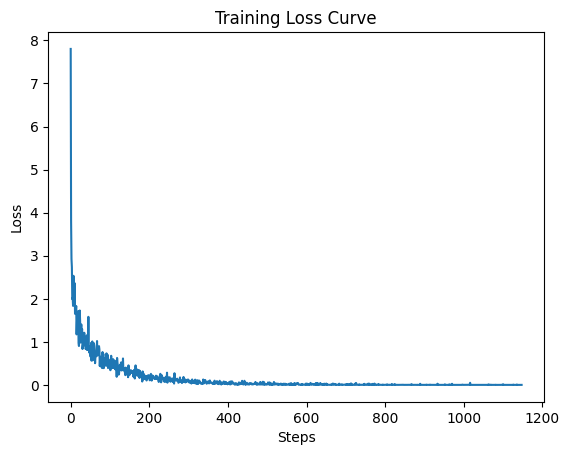

In [9]:
# Redefine the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_cvae.parameters(), lr=0.001)
num_epochs = 1

# Training loop
losses = []
total_steps = len(dataloader) * num_epochs

# Initialize tqdm progress bar
progress_bar = tqdm(total=total_steps, desc="Training", position=0)

for epoch in range(num_epochs):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output, logits = transformer_cvae(batch)
        loss = criterion(output.view(-1, VOCAB_SIZE), batch.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.7f}')
        progress_bar.update(1)
    
    # Print epoch loss
    avg_loss = sum(losses[-len(dataloader):]) / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

# Close the tqdm progress bar
progress_bar.close()

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


In [10]:
# Define a function to generate text using the model
def generate_text(model, sentence, word_to_index, vocab, max_length=SEQUENCE_LENGTH):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize and encode the sentence
        encoded_sentence = tokenize_and_encode(sentence)
        input_tensor = torch.tensor([encoded_sentence]).to(device)
        
        # Pass the encoded sentence through the model
        output, _ = model(input_tensor)
        
        # Convert the output probabilities to predicted token IDs
        _, predicted_ids = torch.max(output, dim=2)
        predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
        # Convert the predicted token IDs back to words
        predicted_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        
        return predicted_sentence

# Modify the training loop to print out a generated sentence at the end of each epoch
def train_and_visualize(model, dataloader, optimizer, criterion, num_epochs, word_to_index, vocab, valid_file_path):
    # Load a validation sentence
    with open(valid_file_path, "r", encoding="utf-8") as file:
        valid_data = file.readlines()
    
    # For simplicity, just use the first sentence from the validation set for visualization
    valid_sentence = valid_data[0].strip()
    
    losses = []
    total_steps = len(dataloader) * num_epochs

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=total_steps, desc="Training", position=0)

    for epoch in range(num_epochs):
        for batch in dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, logits = model(batch)
            loss = criterion(output.view(-1, VOCAB_SIZE), batch.view(-1))
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.7f}')
            progress_bar.update(1)

        # Print epoch loss
        avg_loss = sum(losses[-len(dataloader):]) / len(dataloader)
        print(f"\nEpoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

        # Generate text after each epoch
        generated_sentence = generate_text(model, valid_sentence, word_to_index, vocab)
        print(f"Original Sentence: {valid_sentence}")
        print(f"Generated Sentence: {generated_sentence}\n")

    # Close the tqdm progress bar
    progress_bar.close()

    # Plot the loss curve
    plt.plot(losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

# Now, let's call the modified training loop
train_and_visualize(transformer_cvae, dataloader, optimizer, criterion, num_epochs, word_to_index, vocab, "wikitext-2/wiki.valid.tokens")


Epoch 1/1 | Loss: 0.0004164: 100%|██████████| 1148/1148 [06:56<00:00,  3.27it/s]


Epoch [1/1] - Loss: 0.0006


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [20]:
# Modify the generate_text_debug function to handle the outputs correctly

def generate_text_debug_v2(model, sentence, word_to_index, vocab, max_length=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize and encode the sentence
        encoded_sentence = tokenize_and_encode(sentence)
        input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)  # Ensure type is Long
        
        # Pass the encoded sentence through the model encoder
        logits = model.encoder(input_tensor)
        print(f"Shape of logits: {logits.shape}")
        
        z = model.reparameterize(logits)
        output = model.decoder(input_tensor, z)
        
        # Convert the output probabilities to predicted token IDs
        _, predicted_ids = torch.max(output, dim=2)
        predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
        # Convert the predicted token IDs back to words
        predicted_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        
        return predicted_sentence

# Call the debug function
valid_sentence = "Bring yourself back online."
generated_sentence_debug_v2 = generate_text_debug_v2(transformer_cvae, valid_sentence, word_to_index, vocab)
print(generated_sentence_debug_v2)


Shape of logits: torch.Size([1, 16])
<UNK> <UNK> back <UNK>
